# Finetune EfficientNet-B7


## efficientnetb7_600repetitive


With 600x600 repetitive-padded (with n_mels = 600) melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'efficientnetb7_600repetitive'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MelspectrogramDataset import MelSpectrogramDataset
from cnn.pipeline.Pipeline import Pipeline

Define the model


In [7]:
model = models.efficientnet_b7(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [8]:
# Number of classes
num_classes = 9

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer according to number of classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze the last 3 layers so that they can be fine-tuned
# Adjust the indices based on the actual number of layers in model.features
for idx in [-3, -2, -1]:  # Use negative indices to target the last 3 layers
    for param in model.features[idx].parameters():
        param.requires_grad = True

# Replace classifier
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

num_epochs = 50

C:\Users\profi\AppData\Local\Temp\ipykernel_45108\3408896021.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Prepare datasets and dataloaders


In [10]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=4,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=4,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=4,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 2369/2369 [02:23<00:00, 16.48it/s, Loss=0.3096095621585846, Elapsed=155.2000s, ETA=0.0000s]   


Epoch 1 completed in 1283.3163s
Train Loss: 1.1828547095399427 - Train Accuracy: 54.21406119264602
Validation Loss: 0.8484821427399635 - Validation Accuracy: 66.5470662726889

Epoch 2/50


Validating: 100%|██████████| 2369/2369 [02:23<00:00, 16.49it/s, Loss=0.17614980041980743, Elapsed=155.1129s, ETA=0.0000s]   


Epoch 2 completed in 1273.7608s
Train Loss: 0.8669951691598595 - Train Accuracy: 65.97318016327084
Validation Loss: 0.7545152919035204 - Validation Accuracy: 73.55424229632757

Epoch 3/50


Validating: 100%|██████████| 2369/2369 [02:23<00:00, 16.49it/s, Loss=0.4205714464187622, Elapsed=155.1978s, ETA=0.0000s]     


Epoch 3 completed in 1274.0236s
Train Loss: 0.7501938075991179 - Train Accuracy: 70.9165328689989
Validation Loss: 0.803799928615116 - Validation Accuracy: 69.78682988602786

EarlyStopping counter: 1/5
Epoch 4/50


Validating: 100%|██████████| 2369/2369 [02:23<00:00, 16.49it/s, Loss=0.08288061618804932, Elapsed=155.2246s, ETA=0.0000s]   


Epoch 4 completed in 1273.8274s
Train Loss: 0.6540401711471138 - Train Accuracy: 74.8535763551254
Validation Loss: 0.724502895319027 - Validation Accuracy: 75.32714225411567

Epoch 5/50


Validating: 100%|██████████| 2369/2369 [02:23<00:00, 16.48it/s, Loss=0.07462835311889648, Elapsed=155.4536s, ETA=0.0000s]    


Epoch 5 completed in 1274.5546s
Train Loss: 0.5883543604861514 - Train Accuracy: 77.47450306415504
Validation Loss: 0.7825930018804863 - Validation Accuracy: 77.0578303081469

EarlyStopping counter: 1/5
Epoch 6/50


Validating: 100%|██████████| 2369/2369 [02:23<00:00, 16.50it/s, Loss=0.005164027214050293, Elapsed=155.2712s, ETA=0.0000s]   


Epoch 6 completed in 1274.8622s
Train Loss: 0.5211842456516872 - Train Accuracy: 80.07281608285656
Validation Loss: 0.6819937944309642 - Validation Accuracy: 74.92612916842549

Epoch 7/50


Validating: 100%|██████████| 2369/2369 [02:23<00:00, 16.47it/s, Loss=0.00518098333850503, Elapsed=155.5836s, ETA=0.0000s]    


Epoch 7 completed in 1275.0465s
Train Loss: 0.4681508169920607 - Train Accuracy: 82.09900273625654
Validation Loss: 0.7137083645989422 - Validation Accuracy: 75.98142676234698

EarlyStopping counter: 1/5
Epoch 8/50


Validating: 100%|██████████| 2369/2369 [02:23<00:00, 16.48it/s, Loss=0.06439492106437683, Elapsed=155.4884s, ETA=0.0000s]    


Epoch 8 completed in 1274.8102s
Train Loss: 0.41701848681992 - Train Accuracy: 83.98272314058931
Validation Loss: 0.8280229832337844 - Validation Accuracy: 74.62009286618827

EarlyStopping counter: 2/5
Epoch 9/50


Validating: 100%|██████████| 2369/2369 [02:23<00:00, 16.46it/s, Loss=0.00423414958640933, Elapsed=155.4471s, ETA=0.0000s]    


Epoch 9 completed in 1275.4697s
Train Loss: 0.3771695500320546 - Train Accuracy: 85.17672598991429
Validation Loss: 0.8254026127338626 - Validation Accuracy: 76.78345293372732

EarlyStopping counter: 3/5
Epoch 10/50


Validating: 100%|██████████| 2369/2369 [02:23<00:00, 16.48it/s, Loss=0.033905792981386185, Elapsed=155.4291s, ETA=0.0000s]   


Epoch 10 completed in 1275.3685s
Train Loss: 0.33656023632325066 - Train Accuracy: 86.66922955157052
Validation Loss: 0.8153421704372737 - Validation Accuracy: 76.19248628113128

EarlyStopping counter: 4/5
Epoch 11/50


Validating: 100%|██████████| 2369/2369 [02:23<00:00, 16.45it/s, Loss=0.014677349478006363, Elapsed=155.6885s, ETA=0.0000s]   

Epoch 11 completed in 1275.0526s
Train Loss: 0.2997003405118844 - Train Accuracy: 88.062232875783
Validation Loss: 0.8785770488385992 - Validation Accuracy: 75.06331785563529

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


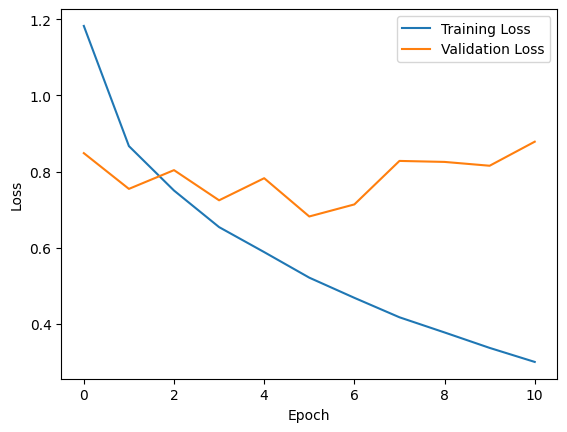

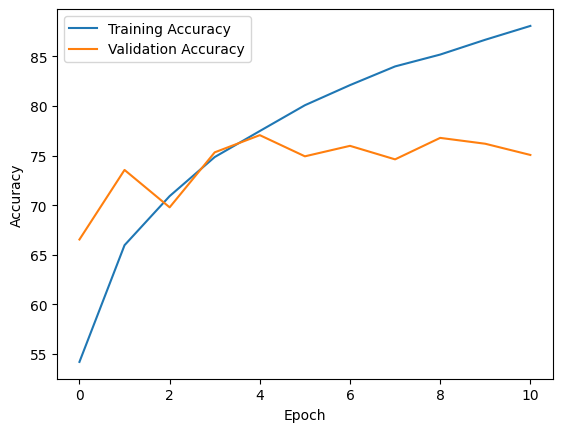

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\cnn\pipeline\Pipeline.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

Evaluating best model on test set...


Testing: 100%|██████████| 2370/2370 [02:34<00:00, 15.38it/s]

Test Accuracy: 0.7708
Test Precision: 0.7860
Test Recall: 0.7708
Test F1-score: 0.7692

              precision    recall  f1-score   support

       Anger       0.70      0.84      0.76       916
       Bored       0.92      0.80      0.85      1098
     Disgust       0.68      0.44      0.54       291
        Fear       0.55      0.56      0.56       308
       Happy       0.89      0.62      0.73      1914
     Neutral       0.68      0.84      0.75      2226
    Question       0.87      0.93      0.90      1139
         Sad       0.81      0.74      0.77       857
    Surprise       0.73      0.83      0.78       728

    accuracy                           0.77      9477
   macro avg       0.76      0.73      0.74      9477
weighted avg       0.79      0.77      0.77      9477



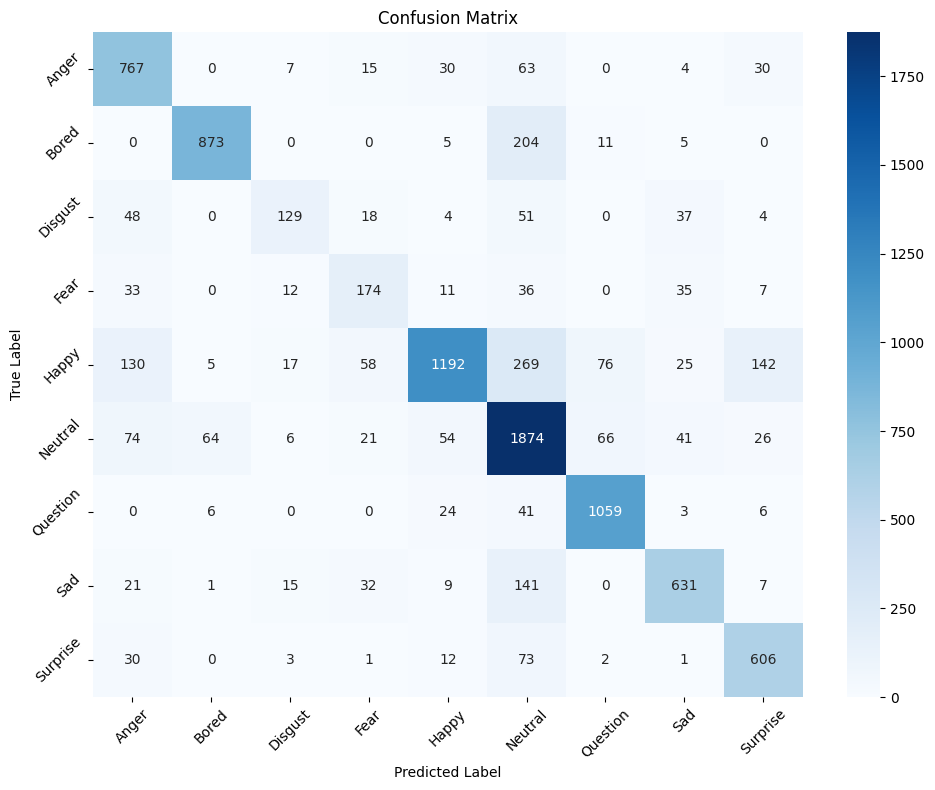

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=5
)